# Методы машинного обучения

В рамках данного туториала мы познакомимся на практике с такими методами машинного обучения, как: 
- knn
- логистическая регрессия
- LDA, QDA,
- SVM
- наивный байесовский классификатор <br>
Манипуляции с данными будем проводить с использованием библиотек sklearn, pandas, numpy, matplotlib и др

В начале, произведем импорт библиотек, которые понадобятся нам в будущем

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

На протяжении всего туториала мы будем работать датасетом, содержащим данные о зернах трех сортов пшеницы, а именно: Kama, Rosa and Canadian. Каждый сорт представлен семидесятью наблюдениями, и для каждого зерна доступны семь атрибутов:
1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove
Необходимо обучить алгоритмы таким образом, чтобы они с максимальной точностью могли определять сорт пшеницы по указанным выше параметрам.
Загрузить данные и получить более подробную информацию о них можно по ссылке: https://archive.ics.uci.edu/ml/datasets/seeds 

Загрузим данные в датафрейм и выведем первые 5 строк. Для загрузки будем использовать метод из библиотеки pandas - read_csv. Методу необходимо передать путь до файла, символ, разделяющий колонки, и имена колонок.

In [68]:
data = pd.read_csv('seeds_dataset.txt', sep="	", names=["area A", "perimeter P", "compactness C = 4*pi*A/P^2", "length of kernel", "width of kernel", "asymmetry coefficient", "length of kernel groove","cultivar"])
data.head() 

,area A,perimeter P,compactness C = 4*pi*A/P^2,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,cultivar
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Опишем данные

In [69]:
print(data.describe())
print("Data shape: "+ str(data.shape))

           area A  perimeter P  compactness C = 4*pi*A/P^2  length of kernel  \
count  210.000000   210.000000                  210.000000        210.000000   
mean    14.847524    14.559286                    0.870999          5.628533   
std      2.909699     1.305959                    0.023629          0.443063   
min     10.590000    12.410000                    0.808100          4.899000   
25%     12.270000    13.450000                    0.856900          5.262250   
50%     14.355000    14.320000                    0.873450          5.523500   
75%     17.305000    15.715000                    0.887775          5.979750   
max     21.180000    17.250000                    0.918300          6.675000   

       width of kernel  asymmetry coefficient  length of kernel groove  \
count       210.000000             210.000000               210.000000   
mean          3.258605               3.700201                 5.408071   
std           0.377714               1.503557            

Построим матрицу рассеяния. Как мы видим, некоторые колонки довольно сильно коррелируют с другими, что не удивительно. Например, периметр зерна связан однозначным отношением с его длиной и шириной. Для построения будем использователь метод scatter_matrix из библиотеки pandas. Параметром alpha задаем размер точки на графике, остальные интуитивно понятны.

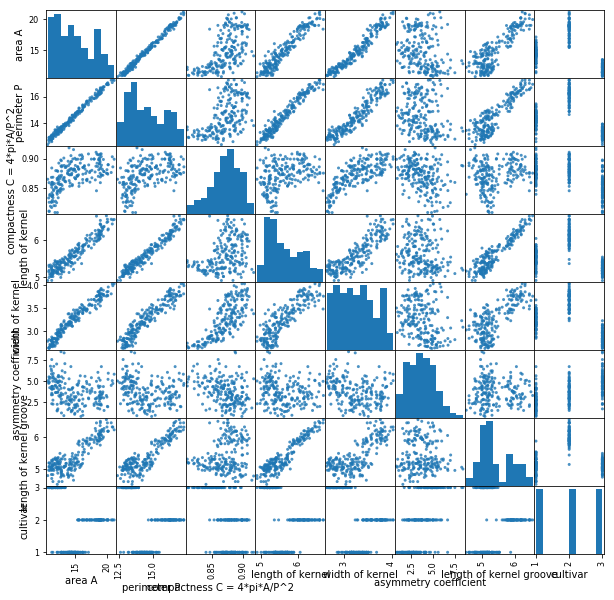

In [70]:
data.corr()
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = 0.8, figsize = (10, 10))
pass

Оценим тип данных. Поскольку NaN-значения и категориальные признаки отсутствуют, преобразования не нужны. В противном случае, из категориальных признаков пришлось бы делать несколько столбцов с бинарными признаками, а пустые значения либо заменять средним, либо выбрасывать строки, содержащие их.

In [71]:
print("Number of NaN-values: " + str(data.isnull().values.sum()))
print("Number of categorical columns: " + str(len([c for c in data.columns if data[c].dtype.name == 'object'])))
print("Number of numerical columns: " + str(len([c for c in data.columns if data[c].dtype.name != 'object'])))

Number of NaN-values: 0
Number of categorical columns: 0
Number of numerical columns: 8


Большая часть алгоритмов машинного обучения, например, knn, чувствительны к масштабированию и корректно работают только с нормализованными данными, поэтому отделив столбец, содержащий информацию о сорте пшеницы, проведем нормализацию. Существует несколько способов нормализации. В данном случае, каждый количественный признак приведем к нулевому среднему и единичному среднеквадратичному отклонению:

In [72]:
x = data.drop(('cultivar'), axis = 1) 
y = data['cultivar']
x = (x - x.mean(axis = 0))/x.std(axis = 0)
x.describe()

,area A,perimeter P,compactness C = 4*pi*A/P^2,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
count,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02
mean,-2.254281e-15,-2.566730e-15,1.402780e-15,-4.132144e-15,-2.622241e-16,3.827626e-16,-1.691768e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.463218e+00,-1.645753e+00,-2.661876e+00,-1.646566e+00,-1.664233e+00,-1.952105e+00,-1.808966e+00
25%,-8.858385e-01,-8.494033e-01,-5.966534e-01,-8.267062e-01,-8.329169e-01,-7.573380e-01,-7.387301e-01
50%,-1.692697e-01,-1.832261e-01,1.037448e-01,-2.370616e-01,-5.719866e-02,-6.730769e-02,-3.765590e-01
75%,8.445808e-01,8.849547e-01,7.099807e-01,7.927006e-01,8.025778e-01,7.106807e-01,9.541143e-01
max,2.176333e+00,2.060336e+00,2.001803e+00,2.361889e+00,2.050213e+00,3.163032e+00,2.323446e+00


Разделим датасет на тестовую и обучающую выборки в соотношении 20%:80%

In [73]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)


##  Кросс-валидация (CV)
Скользящий контроль или кросс-проверка или кросс-валидация — процедура эмпирического оценивания обобщающей способности алгоритмов, обучаемых по прецедентам.
Фиксируется некоторое множество разбиений исходной выборки на две подвыборки: обучающую и контрольную. Для каждого разбиения выполняется настройка алгоритма по обучающей подвыборке, затем оценивается его средняя ошибка на объектах контрольной подвыборки. Оценкой скользящего контроля называется средняя по всем разбиениям величина ошибки на контрольных подвыборках.
Если выборка независима, то средняя ошибка скользящего контроля даёт несмещённую оценку вероятности ошибки. Это выгодно отличает её от средней ошибки на обучающей выборке, которая может оказаться смещённой (оптимистически заниженной) оценкой вероятности ошибки, что связано с явлением переобучения. (http://www.machinelearning.ru/wiki/index.php?title=%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B8%D0%B9_%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8C)

В данном туториале мы будем применять кросс-валидацию для всех алгоритмов классификации

## К-Nearest neighbors (knn)

Метод ближайшего соседа является, пожалуй, самым простым алгоритмом классификации. Классифицируемый объект x относится к тому классу y_i, которому принадлежит ближайший объект обучающей выборки x_i. 

Для повышения надёжности классификации объект относится к тому классу, которому принадлежит большинство из его соседей — k ближайших к нему объектов обучающей выборки x_i. В задачах с двумя классами число соседей берут нечётным, чтобы не возникало ситуаций неоднозначности, когда одинаковое число соседей принадлежат разным классам.

Метод взвешенных ближайших соседей. В задачах с числом классов 3 и более нечётность уже не помогает, и ситуации неоднозначности всё равно могут возникать. Тогда i-му соседу приписывается вес w_i, как правило, убывающий с ростом ранга соседа i. Объект относится к тому классу, который набирает больший суммарный вес среди k ближайших соседей. (Источник: http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B1%D0%BB%D0%B8%D0%B6%D0%B0%D0%B9%D1%88%D0%B5%D0%B3%D0%BE_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B0 )

Для метода knn наиболее существенными являются следующие параметры:<br>
<b>n_neighbors</b> - число соседей, класс которых учитывается при принятии решения<br> 
<b>metric</b> - метрика, с помощью которой вычисляется расстрояние между точками (по дефолту, используется Евклидово расстояние)<br>
<b>weights</b> - алгоритм, с помощью которого вычисляется значимость того или иного соседа (по умолчанию, все соседи имеют одинаковый вес(в таком случае возможна неоднозначность при числе n_neighbors кратном числу классов), так же, часто вес считается на основании расстояния, но можно задавть и кастомную функцию)<br>
О других параметрах можно прочитать в документации http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Построим график зависимости ошибки от количества соседей, которых учитывает алгоритм. 

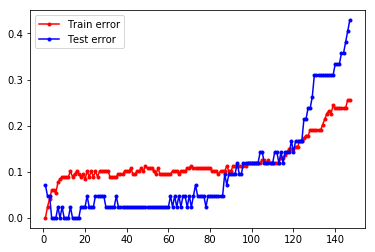

In [74]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
errs_train, errs_test = [],[]
for k in range(1,148):
    knn = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
    errs_train.append(np.mean(knn.predict(x_train)!=y_train))
    errs_test.append(np.mean(knn.predict(x_test)!=y_test))

%matplotlib inline
plt.plot(range(1,148), errs_train, '.-r', label = 'Train error')
plt.plot(range(1,148), errs_test,  '.-b', label = 'Test error')    
plt.legend(loc = 2)
pass

Нетрудно заметить, что лучшие результаты достигаются при значениях "к" примерно от одного до десяти. Посмтроим этот участок более крупно. Переобучение же наступает только при очень больших значениях к

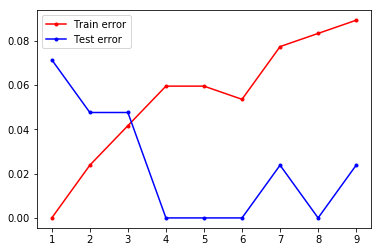

In [75]:
%matplotlib inline
plt.plot(range(1,10), errs_train[:9], '.-r', label = 'Train error')
plt.plot(range(1,10), errs_test[:9],  '.-b', label = 'Test error')    
plt.legend(loc = 'best')
pass

Наивысшая точность для тестовой выборки достигается при к=4,5,8. 

In [76]:
print("Ошибка на обучающей выборке: " + str(errs_train[7]))
print("Ошибка на тестовой выборке: " + str(errs_test[7]))

Ошибка на обучающей выборке: 0.0833333333333
Ошибка на тестовой выборке: 0.0


Применим кросс-валидацию для шести соседей, разбив данные на 10 фрагментов. В результате видим, что нулевая ошибка на тестовой выборке была получена относительно случайно, и реальная ошибка составляет 8%

In [77]:
from sklearn.model_selection import cross_val_score
model = KNeighborsClassifier(n_neighbors = 4)
CV_scores = cross_val_score(model, x, y, cv = 10)
print(str(1-CV_scores))
print(str(1-CV_scores.mean())  + "+-"+ str((1-CV_scores).std() * 2))

[ 0.          0.04761905  0.04761905  0.04761905  0.          0.0952381
  0.04761905  0.04761905  0.19047619  0.23809524]
0.0761904761905+-0.148766660493


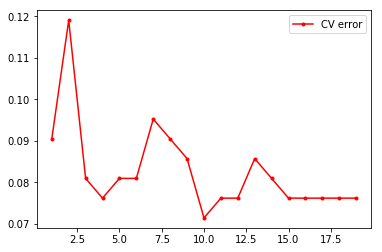

In [78]:
CV_errs = []
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors = k)
    CV_errs.append(1 - cross_val_score(knn, x, y, cv = 10).mean())

plt.plot(range(1,20), CV_errs, '.-r', label = 'CV error')
plt.legend(loc = 'best')

Кросс-валидация показывает, что минимальная ошибка достигается при к = 10

# Линейный дискриминантный анализ (LBA)

<b>Линейный дискриминантный анализ (ЛДА)</b> - это метод поиска линейной комбинации переменных, наилучшим образом разделяющей два или более класса. Чаще всего результат работы линейного дискриминантного анализа используется, как часть линейного классификатора. Другим возможным применением является понижение размерности входных данных перед применением нелинейных алгоритмов классификации. <br>Источник: http://alglib.sources.ru/dataanalysis/lineardiscriminantanalysis.php <br>
Линейный дискриминантный анализ делает два предположения:<br>объекты каждого класса распределены по нормальному закону:
$$
p(x\mid y) = \frac{1}{\sqrt{(2\pi)^d\det\Sigma_y}}e^{-\frac{1}{2}(x-\mu_y)^{\top}\Sigma_y^{-1}(x-\mu_y)}
$$
матрицы ковариации $\Sigma = \Sigma_y$ одинаковы для всех классов.<br>
Классификационное правило в LDA очень простое – новый образец x относится к тому классу, к которому он ближе в метрике Махаланобиса. На практике неизвестные математические ожидания и ковариационная матрица заменяются их оценкам.

Недостатки LDA.

Не работает, когда матрица ковариаций вырождена, например, при большом числе переменных. Требуется регуляризация, например, PCA.

Не пригоден, если ковариационные матрицы классов различны.

Неявно использует предположение о нормальности распределения.

Не позволяет менять уровни ошибок 1-го и 2-го родов.

Достоинства LDA:

Прост в применении. <br> (Источник: http://rcs.chemometrics.ru/Tutorials/classification.htm)

Попробуем применить линейный дескриминантный анализ с разными солверами - оценивая ковариационную матрицу методами наименьших квадратов, разложением собственных значений или не оценивая ковариационную матрицу вообще.

In [79]:
from sklearn import discriminant_analysis
lda_model = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model.fit(x_train, y_train)
err_train = np.mean(y_train != lda_model.predict(x_train))
err_test = np.mean(y_test != lda_model.predict(x_test))
print(err_train, err_test)

0.0416666666667 0.0


In [80]:
lda_model = discriminant_analysis.LinearDiscriminantAnalysis(solver="lsqr")
lda_model.fit(x_train, y_train)
err_train = np.mean(y_train != lda_model.predict(x_train))
err_test = np.mean(y_test != lda_model.predict(x_test))
print(err_train, err_test)

0.0416666666667 0.0


Видно, что при solver="eigen" линейный дискриминантный анализ показал очень низкие результаты, однако, при дурагих солверах точность выше,чем у knn

In [81]:
lda_model = discriminant_analysis.LinearDiscriminantAnalysis(solver="eigen")
lda_model.fit(x_train, y_train)
err_train = np.mean(y_train != lda_model.predict(x_train))
err_test = np.mean(y_test != lda_model.predict(x_test))
print(err_train, err_test)

0.297619047619 0.47619047619


In [82]:
scores = cross_val_score(lda_model, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 0.85714286  0.9047619   0.9047619   0.85714286  1.          0.9047619   1.
  1.          0.71428571  0.66666667]
Accuracy:0.880952380952+-0.218217890236
Error:0.119047619048+-0.218217890236


# Квадратичный дискриминантный анализ (QDA)

Квадратичный дискриминантный анализ сохраняет большинство недостатков LDA.

Не работает, когда матрицы ковариаций  вырождены, например, при большом числе переменных. Требуется регуляризация, например, PCA.

Неявно использует предположение о нормальности распределения.

Не позволяет менять уровни ошибок 1-го и 2-го родов.

Несмотря на эти недостатки, на наших данных пока он показывает лучшую точность

In [83]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [84]:
err_train = np.mean(y_train != qda.predict(x_train))
err_test = np.mean(y_test != qda.predict(x_test))
print(err_train, err_test)

0.047619047619 0.0


In [85]:
scores = cross_val_score(qda, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 1.          0.95238095  0.95238095  0.95238095  1.          0.95238095
  1.          1.          0.71428571  0.80952381]
Accuracy:0.933333333333+-0.181702705032
Error:0.0666666666667+-0.181702705032


# Логистическая регрессия

Логистическая регрессия (Logistic regression) — метод построения линейного классификатора, позволяющий оценивать апостериорные вероятности принадлежности объектов классам.

Суть логистической регрессии заключается в выборе линейной функции,способной разделить классы наблюдений в n-мерном пространстве признаков. Коэффициенты линейной функции вычисляются методом максимального правдоподобия. В процессе предсказания происходит подстановка в функцию набора признаков, и, в зависимости от значения функции (над или под функцией лежит точка), принимается решение о принадлежности наблюдения к тому или иному классу.

На простом примере продемонстрируем работу метода для двух признаков и двух классов

In [86]:
from sklearn.linear_model import LogisticRegression
X=[[1,2,3,2,3,4],[2,3,4,1,2,3]]
X=list(zip(X[0],X[1]))
print(X)
Y=[1,1,1,0,0,0]
logistic_model = LogisticRegression(penalty='l2')
logistic_model.fit(X, Y)

[(1, 2), (2, 3), (3, 4), (2, 1), (3, 2), (4, 3)]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
print(logistic_model.predict([(3,1)]))
print(logistic_model.coef_)
print(logistic_model.intercept_)

[0]
[[-0.87967237  0.87967237]]
[ 0.]


[1, 2, 3, 2, 3, 4]
(-0.87967236943653426, 0) (0.87967236943653426, 0)


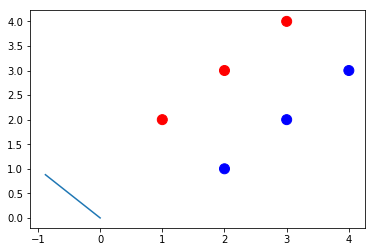

In [88]:
X=[[1,2,3,2,3,4],[2,3,4,1,2,3]]
print(X[0])
line = list(zip(logistic_model.coef_[0],[0, 0]))
print(line[0],line[1])
plt.scatter(X[0], X[1], color = np.array(('b', 'r'))[Y], s = 100)
plt.plot(line[0], line[1])
plt.show()

Теперь проверим данный метод на наших данных

In [89]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(penalty='l1')
logistic_model.fit(x_train, y_train)
err_train = np.mean(y_train != logistic_model.predict(x_train))
err_test = np.mean(y_test != logistic_model.predict(x_test))
print(err_train, err_test)

0.0535714285714 0.0


In [90]:
logistic_model = LogisticRegression(penalty='l2')
logistic_model.fit(x_train, y_train)
err_train = np.mean(y_train != logistic_model.predict(x_train))
err_test = np.mean(y_test != logistic_model.predict(x_test))
print(err_train, err_test)

0.077380952381 0.0


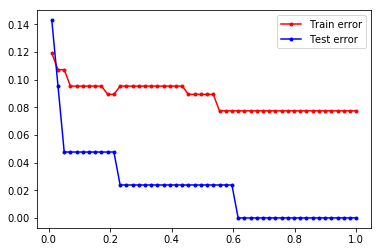

In [91]:
C = np.linspace(.01,1,50)
err_train = []
err_test = []
for reg_str in C:
    logistic_model = LogisticRegression(C = reg_str).fit(x_train, y_train)
    y_train_pred = logistic_model.predict(x_train)
    y_test_pred = logistic_model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(C, err_train, '.-r', label = 'Train error')
plt.plot(C, err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')

In [92]:
scores = cross_val_score(logistic_model, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 1.          0.95238095  0.95238095  1.          1.          0.80952381
  0.95238095  0.9047619   0.9047619   0.9047619 ]
Accuracy:0.938095238095+-0.113088972258
Error:0.0619047619048+-0.113088972258


# Машина опорных векторов (SVM)

Основная идея метода — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с максимальным зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. Алгоритм работает в предположении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.<br>
Преимущества и недостатки SVM:<br>
это наиболее быстрый метод нахождения решающих функций;<br>
метод сводится к решению задачи квадратичного программирования в выпуклой области, которая всегда имеет единственное решение;<br>
метод находит разделяющую полосу максимальной ширины, что позволяет в дальнейшем осуществлять более уверенную классификацию;<br>
метод чувствителен к шумам и стандартизации данных;<br>
не существует общего подхода к автоматическому выбору ядра (и построению спрямляющего подпространства в целом) в случае линейной неразделимости классов.

In [93]:
from sklearn.svm import SVC # "Support Vector Classifier"
svc_model = SVC(kernel = 'linear')
svc_model.fit(x_train, y_train)
err_train = np.mean(y_train != svc_model.predict(x_train))
err_test = np.mean(y_test != svc_model.predict(x_test))
print(err_train, err_test)

0.0714285714286 0.0


In [94]:
scores = cross_val_score(svc_model, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 1.          0.95238095  0.95238095  0.95238095  1.          0.85714286
  1.          0.95238095  0.76190476  0.85714286]
Accuracy:0.928571428571+-0.1490711985
Error:0.0714285714286+-0.1490711985


In [95]:
svc_model = SVC(kernel = 'rbf')
svc_model.fit(x_train, y_train)
err_train = np.mean(y_train != svc_model.predict(x_train))
err_test = np.mean(y_test != svc_model.predict(x_test))
print(err_train, err_test)

0.0714285714286 0.0


In [96]:
scores = cross_val_score(svc_model, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 1.          0.95238095  0.95238095  0.95238095  1.          0.85714286
  0.95238095  0.95238095  0.76190476  0.76190476]
Accuracy:0.914285714286+-0.169298941282
Error:0.0857142857143+-0.169298941282


In [97]:
svc_model = SVC(kernel = 'poly')
svc_model.fit(x_train, y_train)
err_train = np.mean(y_train != svc_model.predict(x_train))
err_test = np.mean(y_test != svc_model.predict(x_test))
print(err_train, err_test)

0.119047619048 0.0238095238095


In [98]:
scores = cross_val_score(svc_model, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 0.76190476  0.9047619   0.95238095  0.95238095  0.95238095  0.9047619   1.
  0.80952381  0.66666667  0.66666667]
Accuracy:0.857142857143+-0.233284737408
Error:0.142857142857+-0.233284737408


In [99]:
svc_model = SVC(kernel = 'sigmoid')
svc_model.fit(x_train, y_train)
err_train = np.mean(y_train != svc_model.predict(x_train))
err_test = np.mean(y_test != svc_model.predict(x_test))
print(err_train, err_test)

0.0833333333333 0.0


In [100]:
scores = cross_val_score(svc_model, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 1.          0.95238095  0.95238095  0.95238095  1.          0.9047619
  0.95238095  0.95238095  0.76190476  0.9047619 ]
Accuracy:0.933333333333+-0.129187237774
Error:0.0666666666667+-0.129187237774


## Наивный Байесовский классификатор

Наи́вный ба́йесовский классифика́тор — простой вероятностный классификатор, основанный на применении теоремы Байеса со строгими (наивными) предположениями о независимости.

В зависимости от точной природы вероятностной модели, наивные байесовские классификаторы могут обучаться очень эффективно. Во многих практических приложениях для оценки параметров для наивных байесовых моделей используют метод максимального правдоподобия; другими словами, можно работать с наивной байесовской моделью, не веря в байесовскую вероятность и не используя байесовские методы.

Несмотря на наивный вид и, несомненно, очень упрощенные условия, наивные байесовские классификаторы часто работают намного лучше во многих сложных жизненных ситуациях.

Достоинством наивного байесовского классификатора является малое количество данных для обучения, необходимых для оценки параметров, требуемых для классификации.

In [101]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)

GaussianNB(priors=None)

In [102]:
err_train = np.mean(y_train != gnb_model.predict(x_train))
err_test = np.mean(y_test != gnb_model.predict(x_test))
print(err_train, err_test)

0.0952380952381 0.0714285714286


In [103]:
scores = cross_val_score(gnb_model, x, y, cv = 10)
print(scores)
print("Accuracy:" + str(scores.mean()) +"+-" + str(scores.std() * 2))
print("Error:" + str(1 - scores.mean())+ "+-" + str(scores.std() * 2))

[ 0.9047619   0.9047619   0.95238095  0.9047619   1.          0.9047619   1.
  0.95238095  0.61904762  0.76190476]
Accuracy:0.890476190476+-0.22151815904
Error:0.109523809524+-0.22151815904


# Random Forest


Random forest — алгоритм машинного обучения, предложенный Лео Брейманом и Адель Катлер, заключающийся в использовании комитета (ансамбля) решающих деревьев. Алгоритм сочетает в себе две основные идеи: метод бэггинга Бреймана, и метод случайных подпространств, предложенный Tin Kam Ho. Алгоритм применяется для задач классификации, регрессии и кластеризации.

In [104]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth = 20, criterion="gini", n_jobs = 2, oob_score = True)
clf = clf.fit(x_train, y_train)

In [105]:
err_train = np.mean(y_train != clf.predict(x_train))
err_test = np.mean(y_test != clf.predict(x_test))
print("Estimators: 100", "Max Depth: 20", err_train, err_test)

Estimators: 100 Max Depth: 20 0.0 0.047619047619


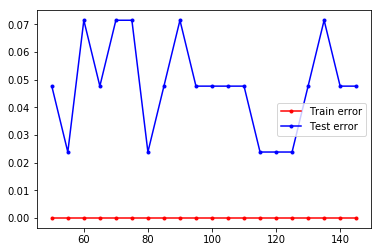

In [106]:
err_train = []
err_test = []
for n_estimators in range(50, 150, 5):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth = 20, criterion="gini", n_jobs = 2,oob_score = True).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(range(50, 150, 5), err_train, '.-r', label = 'Train error')
plt.plot(range(50, 150, 5), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')

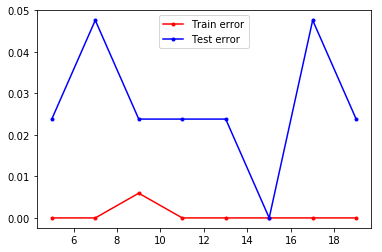

In [107]:
err_train = []
err_test = []
for max_depth in range(5, 20, 2):
    model = RandomForestClassifier(n_estimators=50, max_depth = max_depth, criterion="gini", n_jobs = 2,oob_score = True).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(range(5, 20, 2), err_train, '.-r', label = 'Train error')
plt.plot(range(5, 20, 2), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')

# Extreme Random Trees

В экстремально случайных деревьях выбор признака, по которому поисходит ветвление выбирается абсолютно случайным образом.

In [108]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, max_depth = 20, criterion="gini", n_jobs = 4)
clf = clf.fit(x_train, y_train)

In [109]:
err_train = np.mean(y_train != clf.predict(x_train))
err_test = np.mean(y_test != clf.predict(x_test))
print("Estimators: 100", "Max Depth: 20", err_train, err_test)

Estimators: 100 Max Depth: 20 0.0 0.047619047619


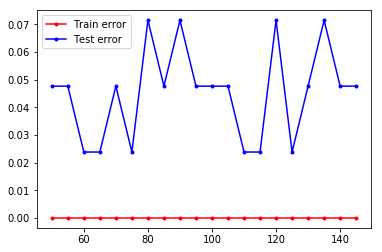

In [110]:
err_train = []
err_test = []
for n_estimators in range(50, 150, 5):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth = 20, criterion="gini", n_jobs = 2).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(range(50, 150, 5), err_train, '.-r', label = 'Train error')
plt.plot(range(50, 150, 5), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')

# AdaBoost

Алгоритм AdaBoost (сокр. от adaptive boosting) — алгоритм машинного обучения, предложенный Йоавом Фройндом (Yoav Freund) и Робертом Шапиром (Robert Schapire). Является мета-алгоритмом, в процессе обучения строит композицию из базовых алгоритмов обучения для улучшения их эффективности. AdaBoost является алгоритмом адаптивного бустинга в том смысле, что каждый следующий классификатор строится по объектам, которые плохо классифицируются предыдущими классификаторами.
AdaBoost вызывает слабый классификатор в цикле. После каждого вызова обновляется распределение весов, которые отвечают важности каждого из объектов обучающего множества для классификации. На каждой итерации веса каждого неверно классифицированного объекта возрастают, таким образом новый классификатор «фокусирует своё внимание» на этих объектах.

### Достоинства
Хорошая обобщающая способность. В реальных задачах (не всегда, но часто) удаётся строить композиции, превосходящие по качеству базовые алгоритмы. Обобщающая способность может улучшаться (в некоторых задачах) по мере увеличения числа базовых алгоритмов.<br>
Простота реализации.<br>
Собственные накладные расходы бустинга невелики. Время построения композиции практически полностью определяется временем обучения базовых алгоритмов.<br>
Возможность идентифицировать объекты, являющиеся шумовыми выбросами.<br>
### Недостатки
AdaBoost склонен к переобучению при наличии значительного уровня шума в данных.<br> Экспоненциальная функция потерь слишком сильно увеличивает веса наиболее трудных объектов, на которых ошибаются многие базовые алгоритмы. Однако именно эти объекты чаще всего оказываются шумовыми выбросами. В результате AdaBoost начинает настраиваться на шум, что ведёт к переобучению. Проблема решается путём удаления выбросов или применения менее агрессивных функций потерь.<br>
AdaBoost требует достаточно длинных обучающих выборок. Другие методы линейной коррекции, в частности, бэггинг, способны строить алгоритмы сопоставимого качества по меньшим выборкам данных.<br>
Жадная стратегия последовательного добавления приводит к построению неоптимального набора базовых алгоритмов. Для улучшения композиции можно периодически возвращаться к ранее построенным алгоритмам и обучать их заново. Для улучшения коэффициентов можно оптимизировать их ещё раз по окончании процесса бустинга с помощью какого-нибудь стандартного метода построения линейной разделяющей поверхности. Рекомендуется использовать для этой цели SVM (машины опорных векторов).
Бустинг может приводить к построению громоздких композиций, состоящих из сотен алгоритмов. Такие композиции исключают возможность содержательной интерпретации, требуют больших объёмов памяти для хранения базовых алгоритмов и существенных затрат времени на вычисление классификаций.

In [111]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                           n_estimators=50, learning_rate = 1)
clf = clf.fit(x_train, y_train)

In [112]:

err_train = np.mean(y_train != clf.predict(x_train))
err_test = np.mean(y_test != clf.predict(x_test))
print("Estimators: 50", "Max Depth: 3", err_train, err_test)

Estimators: 50 Max Depth: 3 0.0 0.0


Построим график зависимости ошибки на тестовой и обучающей выборках от количества деревьев

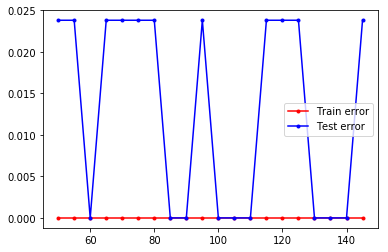

In [113]:
err_train = []
err_test = []
for n_estimators in range(50, 150, 5):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                           n_estimators=n_estimators, learning_rate = 1).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(range(50, 150, 5), err_train, '.-r', label = 'Train error')
plt.plot(range(50, 150, 5), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')

Построим график зависимости ошибки на тестовой и обучающей выборках от максимальной глубины деревьев

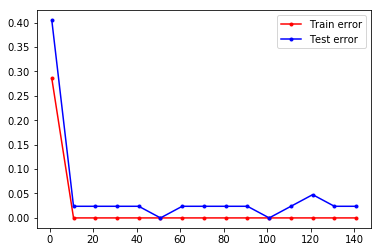

In [114]:
err_train = []
err_test = []
for max_depth in range(1, 150, 10):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), 
                           n_estimators=60, learning_rate = 1).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(range(1, 150, 10), err_train, '.-r', label = 'Train error')
plt.plot(range(1, 150, 10), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')   

Повторим эксперимент при разных значениях замедляющего параметра

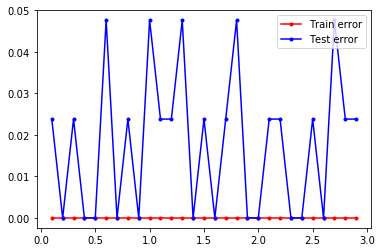

In [115]:
err_train = []
err_test = []
for learning_rate in np.arange(0.1, 3, 0.1):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=90), 
                           n_estimators=60, learning_rate = learning_rate).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(np.arange(0.1, 3, 0.1), err_train, '.-r', label = 'Train error')
plt.plot(np.arange(0.1, 3, 0.1), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best') 

# Gradient Boosted Trees

In [116]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,  max_depth=3, subsample=1.0)
clf = clf.fit(x_train, y_train)

In [117]:
err_train = np.mean(y_train != clf.predict(x_train))
err_test = np.mean(y_test != clf.predict(x_test))
print("Estimators: 100", "Max Depth: 3", err_train, err_test)

Estimators: 100 Max Depth: 3 0.0 0.0


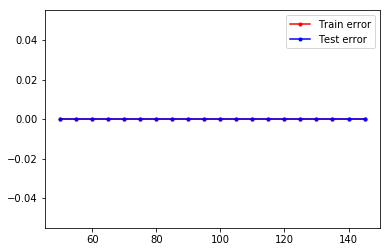

In [118]:
err_train = []
err_test = []
for n_estimators in range(50, 150, 5):
    model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=n_estimators,  max_depth=3, subsample=1.0).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(range(50, 150, 5), err_train, '.-r', label = 'Train error')
plt.plot(range(50, 150, 5), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')

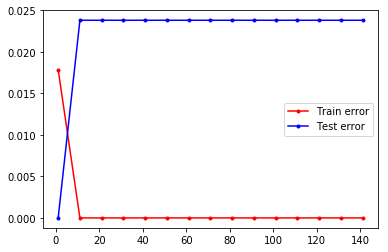

In [119]:
err_train = []
err_test = []
for max_depth in range(1, 150, 10):
    model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,  max_depth=max_depth, subsample=1.0).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(range(1, 150, 10), err_train, '.-r', label = 'Train error')
plt.plot(range(1, 150, 10), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best')  

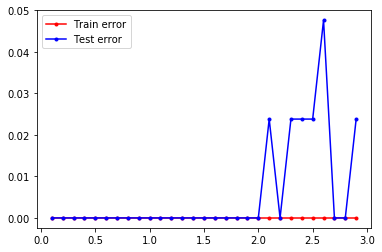

In [120]:
err_train = []
err_test = []
for learning_rate in np.arange(0.1, 3, 0.1):
    model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=60,  max_depth=3, subsample=1.0).fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    err_train.append(np.mean(y_train_pred != y_train))
    err_test.append(np.mean(y_test_pred != y_test))
plt.plot(np.arange(0.1, 3, 0.1), err_train, '.-r', label = 'Train error')
plt.plot(np.arange(0.1, 3, 0.1), err_test, '.-b', label = 'Test error')
plt.legend(loc = 'best') 

# Principal component analysis

Метод главных компонент — один из основных способов уменьшить размерность данных, потеряв наименьшее количество информации. Изобретён Карлом Пирсоном в 1901 году. Применяется во многих областях, в том числе, в эконометрике, биоинформатике, обработке изображений, для сжатия данных, в общественных науках.

Вычисление главных компонент может быть сведено к вычислению сингулярного разложения матрицы данных или к вычислению собственных векторов и собственных значений ковариационной матрицы исходных данных.

Поскольку, AdaBoost и GBT дают стопроентную классификацию в силу постоты данных, возьмем алгоритм, который показал наихудшие результаты, а именно Наивный Байесовский классификатор - 90% точности на обучающей и тестовой выборках

In [121]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)

GaussianNB(priors=None)

In [124]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

x = []
y1 = []
y2 = []
for i in range(1, 7):
    pca = PCA(n_components=i)
    X_train_new = pca.fit_transform(x_train)
    X_test_new = pca.transform(x_test)
    
    lda_model = LinearDiscriminantAnalysis(store_covariance=True)
    lda_model.fit(X_train_new, y_train)

    err_train = np.mean(y_train != lda_model.predict(X_train_new))
    err_test = np.mean(y_test != lda_model.predict(X_test_new))
    
    y1.append(err_test)
    y2.append(err_train)
    x.append(i)

    print("Number of components =", i ,err_train, err_test)

Number of components = 1 0.14880952381 0.0952380952381
Number of components = 2 0.0952380952381 0.0238095238095
Number of components = 3 0.0952380952381 0.0238095238095
Number of components = 4 0.0416666666667 0.0
Number of components = 5 0.0416666666667 0.0
Number of components = 6 0.0357142857143 0.0


In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(x,y2, label = 'Train error')
plt.plot(x,y1, label = 'Test error')
plt.xlabel('Number of components')
plt.ylabel('Error')
plt.legend()
plt.grid()

Начиная с четырех компонент ошибка на тестовой выборке уменьшается до нуля

# Выводы

В рамках данного туториала мы рассмотрели следующие методы машинного обучения: Random Forests, Extreme Random Trees, AdaBoost, Gradient Boosted Trees,knn,
логистическая регрессия,LDA, QDA,SVM, наивный байесовский классификатор, а так же, научились пользоваться такими библиотеками, как: sklearn, pandas, numpy, matplotlib и др

Наивысшую точность на показали методы AdaBoost и GradientBoostedTrees.

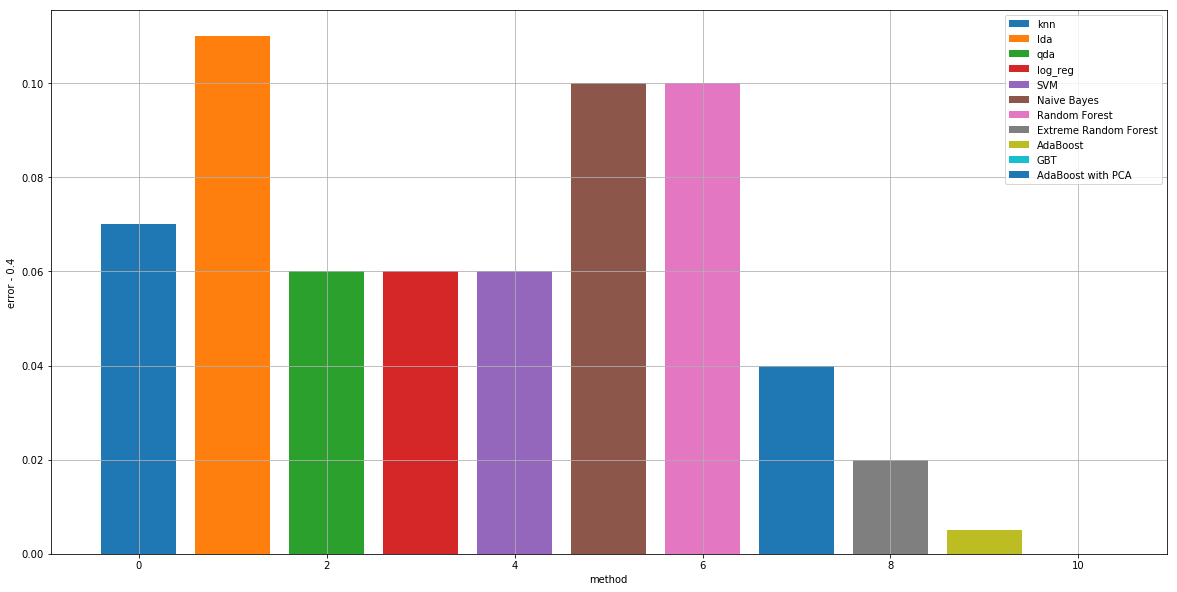

In [126]:
plt.figure(figsize = (20, 10))
plt.bar([0],[0.07], label = "knn")
plt.bar([1],[0.11], label = "lda")
plt.bar([2],[0.06], label = "qda")
plt.bar([3],[0.06], label = "log_reg")
plt.bar([4],[0.06], label = "SVM")
plt.bar([5],[0.1], label = "Naive Bayes")
plt.bar([6],[0.1], label = "Random Forest")
plt.bar([8], [0.02], label = "Extreme Random Forest")
plt.bar([9], [0.005], label = "AdaBoost")
plt.bar([10], [0], label = "GBT")
plt.bar([7], [0.04], label = "AdaBoost with PCA")

plt.xlabel('method')
plt.ylabel('error - 0.4')
plt.legend()
plt.grid()